In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
from scipy.interpolate import UnivariateSpline
import os

data_dir = "/home/wecapstor3/capn/capn100h/neutrino_eff_area_files"

# functions

In [3]:
def mask_invalid(xs, ys):

    mask = np.diff(xs) <= 0

    if np.any(mask):
        valid_mask = np.ones_like(xs, dtype=bool)
        valid_mask[np.argwhere(mask)] = 0
        xs = xs[valid_mask]
        ys = ys[valid_mask]
    return xs, ys

class CrossSection:
    """
    DIS Cross Section

    Reads a cross-section table in nuSQuIDS format
    """

    def __init__(self, filename=os.path.join(data_dir, "csms_square.h5")):
        keys = ["CC_nu", "CC_nubar", "NC_nu", "NC_nubar"]
        self.total_xsec_splines = {}
        self.diff_xsec_splines = {}

        self.y_sampling_splines = {}

        with h5py.File(filename) as hdl:
            self._logenergies = hdl["energies"][:] -9 # GeV

            zs = hdl["zs"][:]
            for key in keys:
                logsigma = hdl["s_"+key][:] # log10(cm^2)
                self.total_xsec_splines[key] = UnivariateSpline(self._logenergies, logsigma, s=0)

                splines = {}
                for e_ix, _ in enumerate(self._logenergies):
                    diff_xs = hdl["dsdy_"+key][:, e_ix]

                    cumu = np.cumsum(diff_xs)
                    cumu = cumu / cumu[-1]

                    inverted_cumu = UnivariateSpline(cumu,  zs, s=0, ext=3)
                    splines[e_ix] = inverted_cumu
                self.y_sampling_splines[key] = splines
        

        self.min_e = 10**np.min(self._logenergies)
        self.max_e = 10**np.max(self._logenergies)

       
        # Calculate mean outgoing lepton energies

        loge_grid = np.linspace(2, 9, 300)
        self.mean_elep_splines = {}
        for key in keys:
            mean_elep = np.log10([np.average(self.sample_e_lep(10**le, size=50000, which=key)) for le in loge_grid])
            self.mean_elep_splines[key] = UnivariateSpline(loge_grid, mean_elep, s=0)
   
    def z(self, e_lep, e_nu):
        return (e_lep - self.min_e)/(e_nu - self.min_e)

    def e_lep(self, z, e_nu):
        return z*(e_nu - self.min_e) + self.min_e


    def total_xsec(self, energy, which="CC_nu"):
        """Total cross section"""
        return 10 ** self.total_xsec_splines[which](np.log10(energy))
        

    def _get_y_sampling_spline(self, energy, which):
        if (energy < 1E2) or (energy > 1E9):
            raise RuntimeError("Energy outside range")
        """Sample outgoing lepton energy from differential x-section"""
        lookup = np.searchsorted(self._logenergies, np.log10(energy))
        if lookup < 0:
            raise RuntimeError("Energy below minimum energy")
    
        if lookup >= len(self._logenergies):
            raise RuntimeError("Energy above minimum energy")
        
        
        spline = self.y_sampling_splines[which][lookup]
        return spline


    def sample_e_lep(self, energy, size=None, which="CC_nu"):
        
        spline = self._get_y_sampling_spline(energy, which)
        z = spline(np.random.uniform(size=size))

        return self.e_lep(z, energy)
    
    def mean_e_lep(self, energy, which="CC_nu"):
        return 10**self.mean_elep_splines[which](np.log10(energy))


class TransmissionProb:
    """Convenience wrapper for transmission probability"""
    def __init__(self, filename=os.path.join(data_dir, "transm_inter_splines.pickle")):
       data = pickle.load(open(filename, "rb"))
       self.splines = data["transmission_prob"]

    def __call__(self, cos_theta, energy, flavor="numu"):
        return self.splines[flavor](cos_theta, np.log10(energy), grid=False)
    

xsec = CrossSection()
transmission = TransmissionProb()   

In [4]:
def projected_area(cos_theta, cyl_radius, cyl_height):
    """Calculate projected area of cylinder for a given direction"""
    cap = np.pi*cyl_radius**2
    sides = 2*cyl_radius*cyl_height
    return cap*abs(cos_theta) + sides*np.sqrt(1 - cos_theta**2)

def cyl_volume(cyl_radius, cyl_height):
    """Calculate cylinder volume"""
    return np.pi*cyl_radius**2*cyl_height

def average_chord_length(cos_theta, cyl_radius, cyl_height):
    """Calculate average chord length of cylinder for a given direction"""
    mask = cos_theta == 0
    result = np.empty_like(cos_theta)
    result[mask] = np.pi * cyl_radius / 2

    ct_masked = cos_theta[~mask]
    result[~mask] = cyl_radius / ((cyl_radius / (cyl_height / abs(ct_masked))) + 2/np.pi*np.sqrt(1 - (ct_masked * ct_masked)))
    return result


def muon_range(energy):
    """
    Approximate muon range
    
    Values taken from MMC paper
    """
    a = 0.212/1.2
    b = 0.251e-3/1.2
    return np.log(1 + energy * b/a) / b

def interaction_prob(cos_theta, energy, cyl_radius, cyl_height, xsec, which="CC_nu", extend_range=False):
    """
    Calculate neutrini interaction probability.
    
    Parameters:
    -----------
    - cos_theta
    - energy
    - cyl_radius
    
    """    
    number_density = 33.3679E21 # 1/cm^-3
    nucleon_density = 18 * number_density
    
    chord_len = average_chord_length(cos_theta, cyl_radius, cyl_height) * 1E2 # cm

    if extend_range:
        #extend by muon range
        #get muon energy
        mean_e_mu = xsec.mean_e_lep(energy, which=which)
    
        chord_len += muon_range(mean_e_mu) * 1E2

    lamb = 1 / (xsec.total_xsec(energy, which) * nucleon_density)

    return 1- np.exp(-chord_len / lamb)


def effective_area(cos_theta, energy, cyl_radius, cyl_height, xsec, transmission, flavor="numu", average_nu_nubar=True):
    """Calculate neutrino effective area"""

    tprob = transmission(cos_theta, energy, flavor=flavor)

    if average_nu_nubar:
        factor = 0.5
    else:
        factor = 1
    
    int_prob_CC = factor * (
        interaction_prob(cos_theta, energy, cyl_radius, cyl_height, xsec, which="CC_nu", extend_range=flavor=="numu") +
        interaction_prob(cos_theta, energy, cyl_radius, cyl_height, xsec, which="CC_nubar", extend_range=flavor=="numu")
    )
    int_prob_NC = factor * (
        interaction_prob(cos_theta, energy, cyl_radius, cyl_height, xsec, which="NC_nu") +
        interaction_prob(cos_theta, energy, cyl_radius, cyl_height, xsec, which="NC_nubar")
    )
    int_prob = int_prob_CC + int_prob_NC
    proj_a = projected_area(cos_theta, cyl_radius, cyl_height)
    return tprob * int_prob * proj_a


# cross section

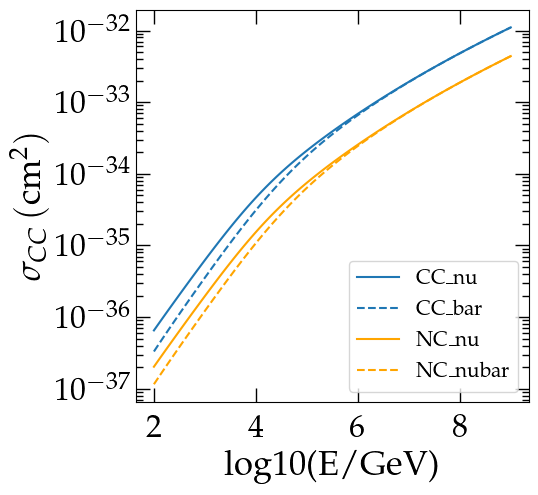

In [5]:
logE = np.linspace(2, 9, 100)
plt.plot(logE, xsec.total_xsec(10**logE, which="CC_nu"), color="tab:blue", label="CC_nu")
plt.plot(logE, xsec.total_xsec(10**logE, which="CC_nubar"), ls="--", color="tab:blue", label="CC_bar")

plt.plot(logE, xsec.total_xsec(10**logE, which="NC_nu"), color="orange", label="NC_nu")
plt.plot(logE, xsec.total_xsec(10**logE, which="NC_nubar"), ls="--", color="orange", label="NC_nubar")
plt.semilogy()
plt.xlabel("log10(E/GeV)")
plt.ylabel(r"$\sigma_{CC} \, (\mathrm{cm}^2)$")
plt.legend()

# effective area

## aeff averaged vs energy

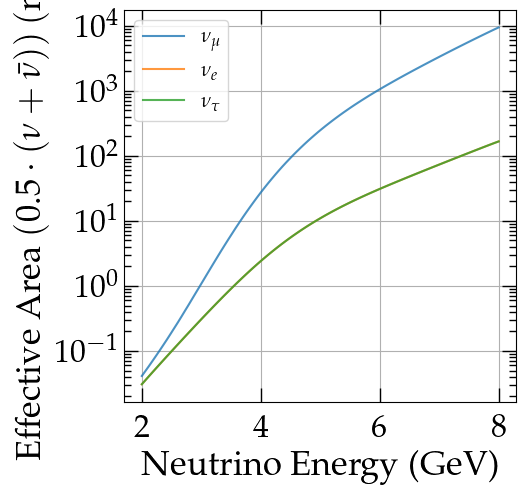

In [6]:
log_energies = np.linspace(2, 8, 100)
ct = np.linspace(-1, 1, 101)
CT, E = np.meshgrid(ct, 10**log_energies, indexing="ij")

a_eff = effective_area(CT, E, 500, 1000, xsec=xsec, transmission=transmission, flavor="numu")
plt.plot(log_energies, np.average(a_eff, axis=0), label=r"$\nu_\mu$", alpha=0.8)

a_eff = effective_area(CT, E, 500, 1000, xsec=xsec, transmission=transmission, flavor="nue")
plt.plot(log_energies, np.average(a_eff, axis=0), label=r"$\nu_e$", alpha=0.8)

# Note: Tau range not yet included
a_eff = effective_area(CT, E, 500, 1000, xsec=xsec, transmission=transmission, flavor="nutau")
plt.plot(log_energies, np.average(a_eff, axis=0), label=r"$\nu_\tau$", alpha=0.8)

plt.semilogy()
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel(r"Effective Area $(0.5 \cdot (\nu+\bar{\nu})) \, (\mathrm{m}^2) $")
plt.grid()
plt.legend()

## aeff averaged vs coszen

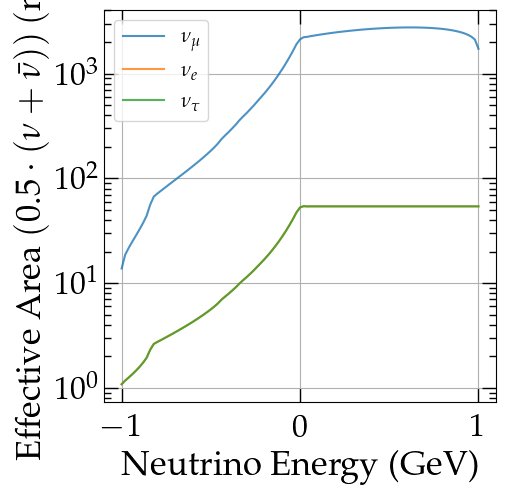

In [7]:
a_eff = effective_area(CT, E, 500, 1000, xsec=xsec, transmission=transmission, flavor="numu")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_\mu$", alpha=0.8)

a_eff = effective_area(CT, E, 500, 1000, xsec=xsec, transmission=transmission, flavor="nue")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_e$", alpha=0.8)

# Note: Tau range not yet included
a_eff = effective_area(CT, E, 500, 1000, xsec=xsec, transmission=transmission, flavor="nutau")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_\tau$", alpha=0.8)


plt.semilogy()
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel(r"Effective Area $(0.5 \cdot (\nu+\bar{\nu})) \, (\mathrm{m}^2) $")
plt.grid()
plt.legend()

## compare aeff for different geometries

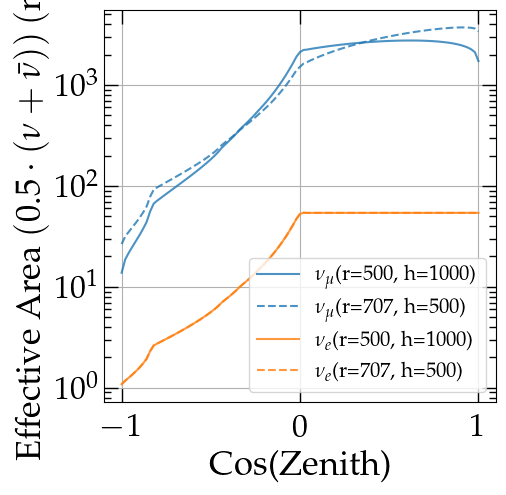

In [8]:
r1 = 500
h1 = 1000
r2 = 500*np.sqrt(2)
h2 = 1000 / 2

a_eff = effective_area(CT, E, r1, h1, xsec=xsec, transmission=transmission, flavor="numu")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_\mu$" + f"(r={r1}, h={h1})", alpha=0.8, color="tab:blue")



a_eff = effective_area(CT, E, r2, h2, xsec=xsec, transmission=transmission, flavor="numu")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_\mu$" + f"(r={r2:.0f}, h={h2:.0f})", alpha=0.8, color="tab:blue", ls="--")

a_eff = effective_area(CT, E, r1, h1, xsec=xsec, transmission=transmission, flavor="nue")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_e$" + f"(r={r1:.0f}, h={h1:.0f})", alpha=0.8, color="tab:orange")

a_eff = effective_area(CT, E, r2, h2, xsec=xsec, transmission=transmission, flavor="nue")
plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_e$" + f"(r={r2:.0f}, h={h2:.0f})", alpha=0.8, color="tab:orange", ls="--")

# Note: Tau range not yet included
#a_eff = effective_area(CT, E, 500, 1000, "nutau")
#plt.plot(ct, np.average(a_eff, axis=1), label=r"$\nu_\tau$", alpha=0.8)


plt.semilogy()
plt.xlabel("Cos(Zenith)")
plt.ylabel(r"Effective Area $(0.5 \cdot (\nu+\bar{\nu})) \, (\mathrm{m}^2) $")
plt.grid()
plt.legend()

# compare event numbers

In [10]:
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sns


plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import astro_flux
from settings import (
    E0_NGC,
    LIVETIME,
)
import settings as st

from collections import namedtuple
from fluxes import PL_flux
import pandas as pd
from itertools import product
from aeff_calculations import setup_coordinates, setup_aeff_grid, earth_rotation

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


## example

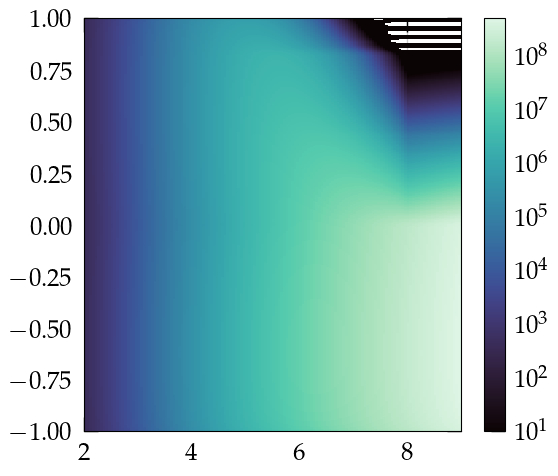

In [11]:
CT, E = np.meshgrid(-st.sindec_mids, 10**st.logE_mids, indexing="ij")
r_base = 500
h_base = 1000

aeff_2d = 1E4 * effective_area(
    CT, E, r_base, h_base, xsec=xsec, transmission=transmission, flavor="numu"
)

plt.figure(figsize=(6,5))
plt.pcolormesh(st.logE_bins, st.sindec_bins, aeff_2d, norm=LogNorm(vmin=10))
plt.colorbar()

# PS style

In [12]:
r_base = 500
h_base = 1000
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=1,
)

soft_flux = PL_flux(1E-14, 3.2, E0_NGC, "powerlaw")
hard_flux = PL_flux(1E-15, 2, E0_NGC, "powerlaw")

In [13]:
aeff_factor_signal = calc_aeff_factor(aeff_2d, dec=0, **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=soft_flux,
)
print("dec=0, soft flux:", np.sum(k_s))

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=hard_flux,
)
print("dec=0, hard flux:", np.sum(k_s))

dec=0, soft flux: 228.27327021713253
dec=0, hard flux: 56.26736626018875


## rotation test

In [14]:
aeff_2d_base = 1e4 * effective_area(
    CT, E, r_base, h_base, xsec=xsec, transmission=transmission, flavor="numu"
)

aeff_2d_base[:len(CT)//2] = 0



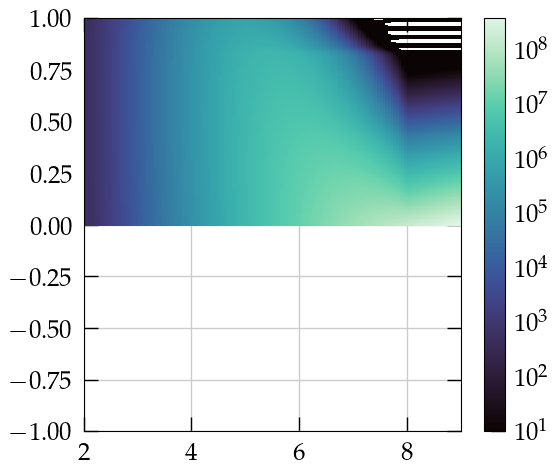

In [15]:
plt.figure(figsize=(6,5))
plt.pcolormesh(st.logE_bins, st.sindec_bins, aeff_2d_base, norm=LogNorm(vmin=10))
plt.colorbar()


In [16]:
# aeff rotation
grid2d, _ = setup_aeff_grid(
    aeff_2d_base.T,
    st.sindec_mids,
    st.ra_mids,
    st.ra_width,
    local=True,
    log_int=False,
)
hp_coords, eq_coords = setup_coordinates()
detector = "Horizon"
aeff_2d = earth_rotation(
    st.poles[detector]["lat"],
    st.poles[detector]["lon"],
    eq_coords,
    hp_coords,
    grid2d,
    st.ra_width,
    log_aeff=False,
)


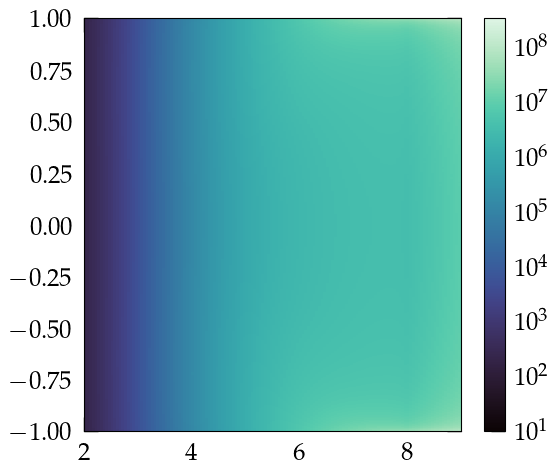

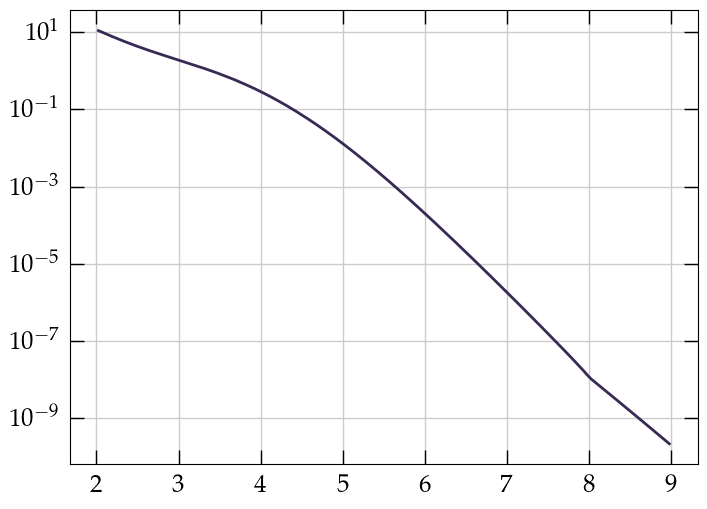

In [17]:
aeff_factor_signal = calc_aeff_factor(aeff_2d.T, dec=np.deg2rad(0), **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=soft_flux,
)
plt.figure(figsize=(6, 5))
plt.pcolormesh(st.logE_bins, st.sindec_bins, aeff_2d.T, norm=LogNorm(vmin=10))
plt.colorbar()

plt.figure()
plt.plot(st.logE_mids, k_s)
plt.yscale("log")

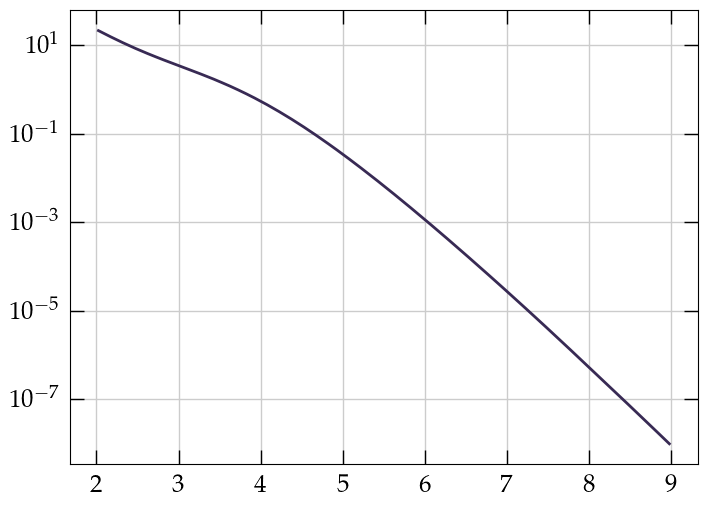

In [18]:
aeff_factor_signal = calc_aeff_factor(aeff_2d_base, dec=np.deg2rad(0), **src_config)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=soft_flux,
)

plt.figure()
plt.plot(st.logE_mids, k_s)
plt.yscale("log")

## test different geometries

In [19]:
results = []

for _rb, _hb, dec, dets, spec in product(
    np.arange(r_base, 6 * r_base + 1, step=250),
    [750, 1000, 1500],
    [0, 45, 90],
    ["IceCube", "KM3NeT", "Horizon"],
    ["hard", "soft"],
):

    aeff_2d_base = 1e4 * effective_area(
        CT, E, _rb, _hb, xsec=xsec, transmission=transmission, flavor="numu"
    )
    aeff_2d_base[: len(CT) // 2] = 0  # set southern hemisphere to zero
    # aeff rotation
    grid2d, _ = setup_aeff_grid(
        aeff_2d_base.T,
        st.sindec_mids,
        st.ra_mids,
        st.ra_width,
        local=True,
        log_int=False,
    )
    hp_coords, eq_coords = setup_coordinates()

    aeff_2d = earth_rotation(
        st.poles[dets]["lat"],
        st.poles[dets]["lon"],
        eq_coords,
        hp_coords,
        grid2d,
        st.ra_width,
        log_aeff=False,
    )

    aeff_factor_signal = calc_aeff_factor(aeff_2d.T, dec=np.deg2rad(dec), **src_config)
    # aeff_factor_signal = calc_aeff_factor(aeff_2d_base, dec=np.deg2rad(dec), **src_config)
    if spec == "hard":
        _flux = hard_flux
    elif spec == "soft":
        _flux = soft_flux
    else:
        raise ValueError("no spectrum found")

    k_s = astro_flux(
        aeff_factor_signal,
        st.emids,
        energy_resolution=None,
        phi_scaling=1,
        flux_shape=_flux,
    )

    results.append(
        {
            "radius_rel": _rb / r_base,  # relative radius change
            "radius_abs": _rb,  # absolute radius change
            "height_rel": _hb / h_base,  # relative height change
            "height_abs": _hb,  # absolute height change
            "dec": dec,  # zenith of sources (IC coordinates)
            "n_ev_abs": np.sum(k_s),  # absolute sum of events per source
            "detector": dets,  # detector name
            "spectrum": spec,
        }
    )
results = pd.DataFrame(results)


In [21]:
results.to_pickle("../../local/geometry_scaling_n_ev.pckl")

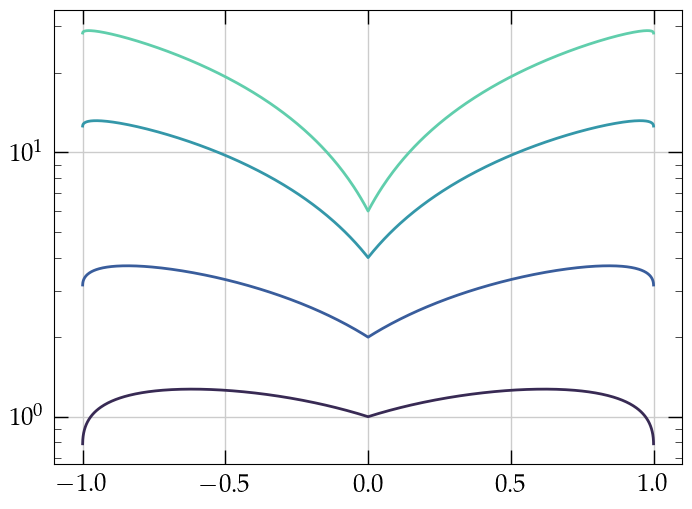

In [ ]:
plt.plot(st.sindec_mids, projected_area(st.sindec_mids, 0.5, 1))
plt.plot(st.sindec_mids, projected_area(st.sindec_mids, 1, 1))
plt.plot(st.sindec_mids, projected_area(st.sindec_mids, 2, 1))
plt.plot(st.sindec_mids, projected_area(st.sindec_mids, 3, 1))
plt.yscale("log")

In [22]:
results["side_area_rel"] = results.height_rel * results.radius_rel
results["top_area_rel"] = results.radius_rel**2
results["volume_rel"] = results.height_rel * results.radius_rel**2
results["volume_abs"] = results.height_abs * np.pi * results.radius_abs**2
results["volume_rel**2/3"] = results.volume_rel ** (2 / 3)
results["volume_abs**2/3"] = results.volume_abs ** (2 / 3)

results["n_ev_rel"] = (
    results.groupby(["dec", "spectrum", "detector"])
    .apply(
        lambda x: x.n_ev_abs
        / x.loc[(x.radius_rel == 1) & (x.height_rel == 1)].n_ev_abs.iloc[0]
    )
    .reset_index(level=[0, 1, 2])
    .sort_index().n_ev_abs
)


In [23]:
results["projected_area_abs"] = (
    results.groupby("dec")
    .apply(
        lambda x: projected_area(np.sin(np.deg2rad(x.dec)), x.radius_abs, x.height_abs)
    )
    .reset_index(level=0, drop=True)
)

results["projected_area_rel"] = (
    results.groupby("dec")
    .apply(
        lambda x: x.projected_area_abs
        / x.loc[(x.radius_rel == 1) & (x.height_rel == 1)].projected_area_abs.iloc[0]
    )
    .reset_index(level=0, drop=True)
)

## evaluation

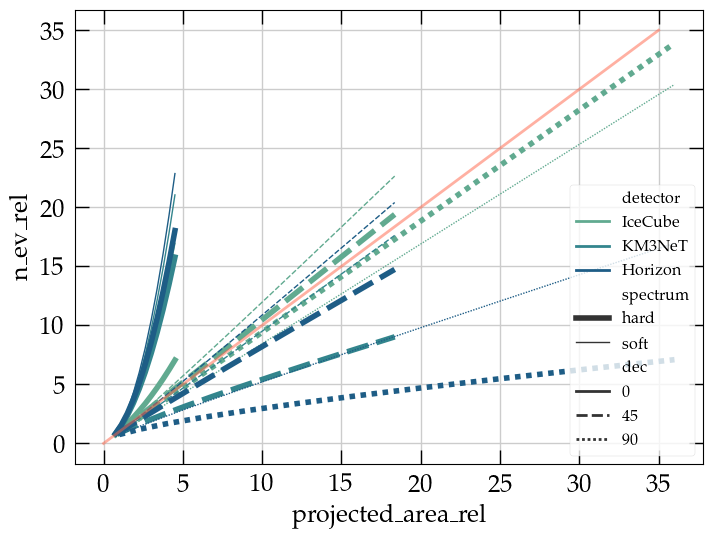

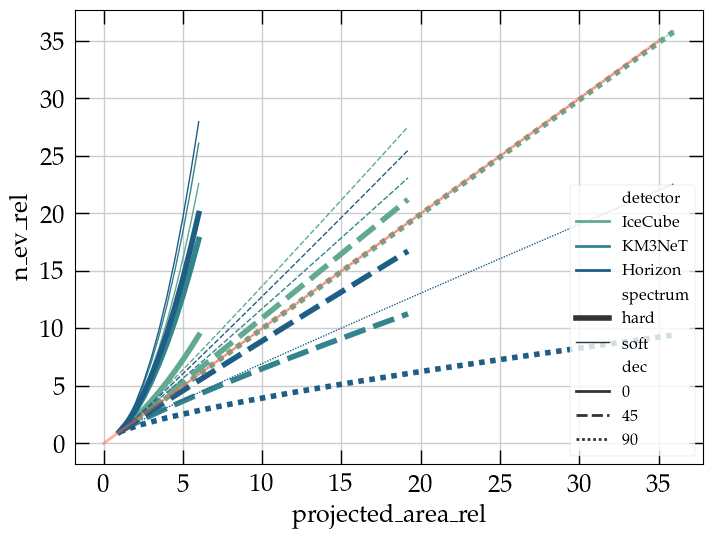

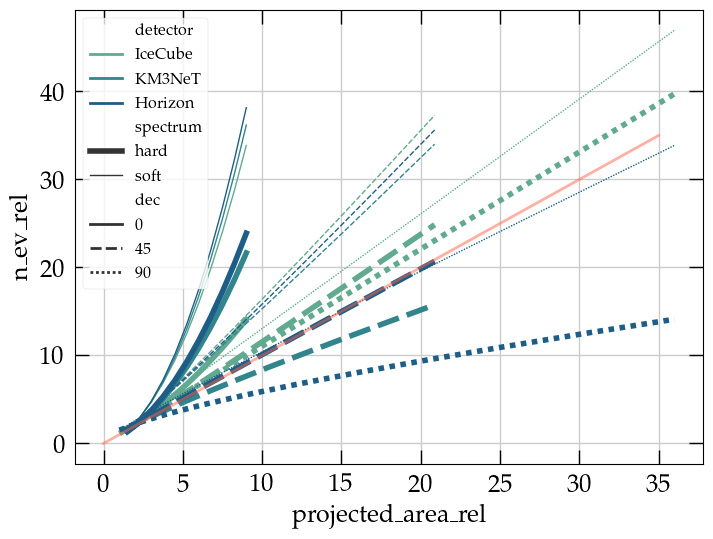

In [ ]:
### grid?
for ii, df in results.groupby("height_rel"):
    plt.figure()
    ax = sns.lineplot(
        data=df,
        x="projected_area_rel",
        y="n_ev_rel",
        size="spectrum",
        style="dec",
        hue="detector",
        palette="crest",
    )

    plt.plot([0, 35], [0, 35], color="tomato", ls="-", alpha=0.5)
    plt.legend(fontsize="small")

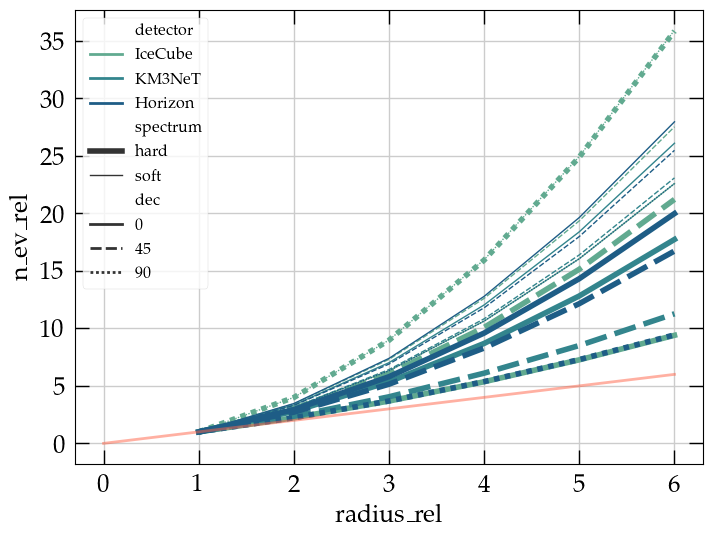

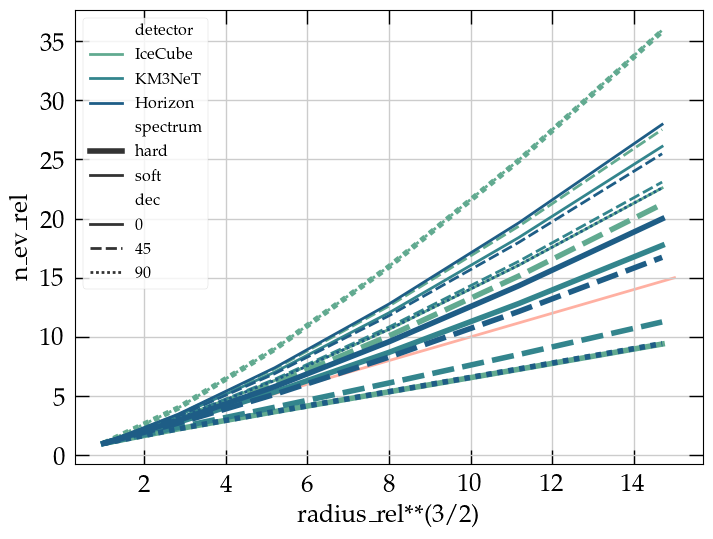

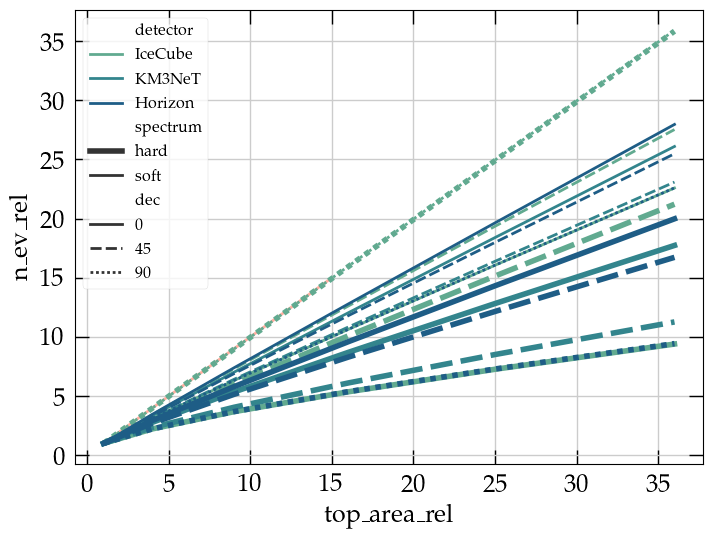

In [ ]:
ax = sns.lineplot(
    data=results,
    x="radius_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
)

plt.plot([0, 6], [0, 6], color="tomato", ls="-", alpha=0.5)
plt.legend(fontsize="small")

results["radius_rel**(3/2)"] = results.radius_rel ** (3 / 2)
plt.figure()
ax = sns.lineplot(
    data=results,
    x="radius_rel**(3/2)",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([1, 15], [1, 15], color="tomato", ls="-", zorder=0, alpha=0.5)

plt.figure()
ax = sns.lineplot(
    data=results,
    x="top_area_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([1, 15], [1, 15], color="tomato", ls="-", zorder=0, alpha=0.5)

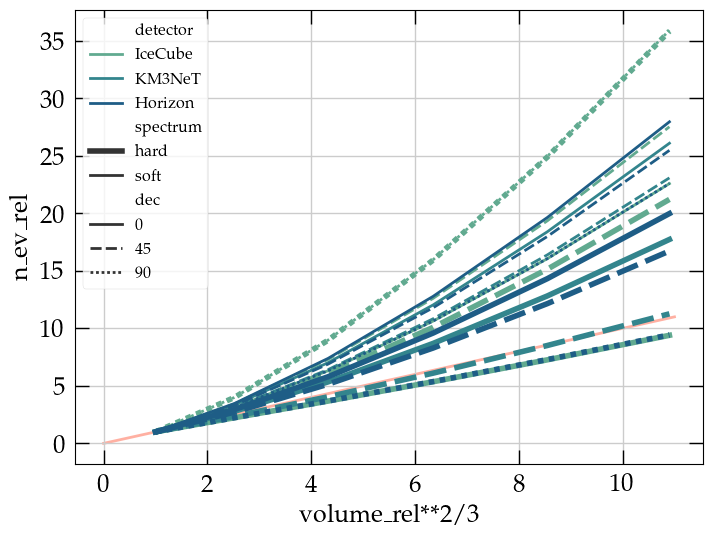

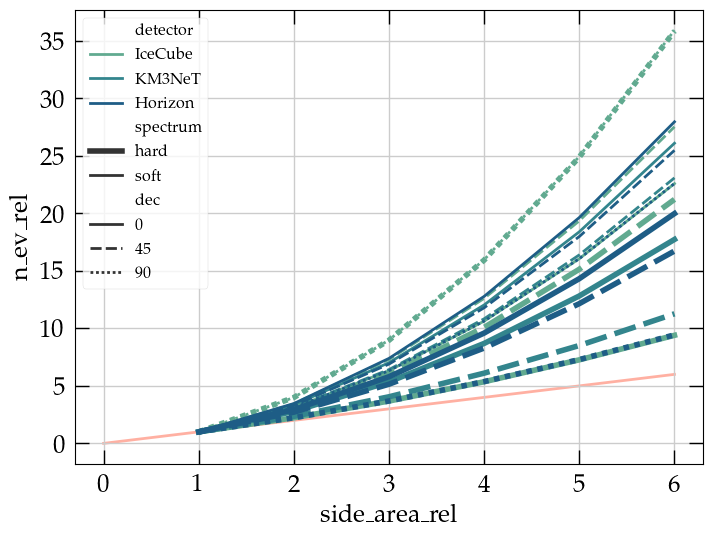

In [ ]:
plt.figure()
ax = sns.lineplot(
    data=results,
    x="volume_rel**2/3",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([0, 11], [0, 11], color="tomato", ls="-", zorder=0, alpha=0.5)
plt.figure()
ax = sns.lineplot(
    data=results,
    x="side_area_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([0, 6], [0, 6], color="tomato", ls="-", zorder=0, alpha=0.5)

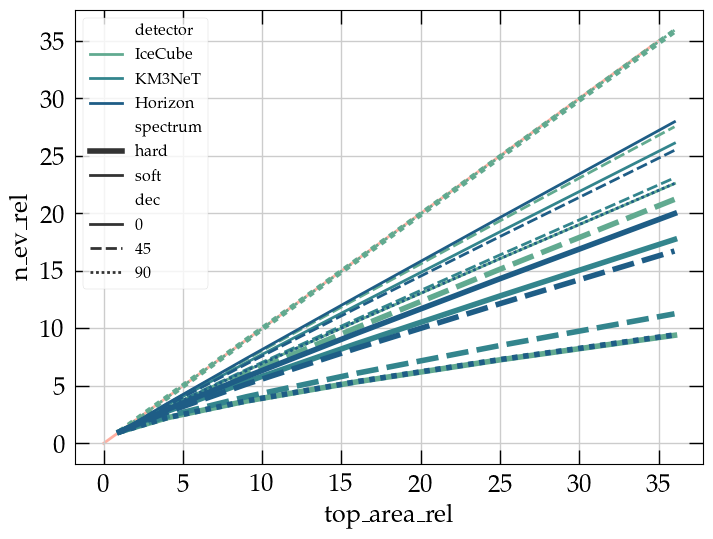

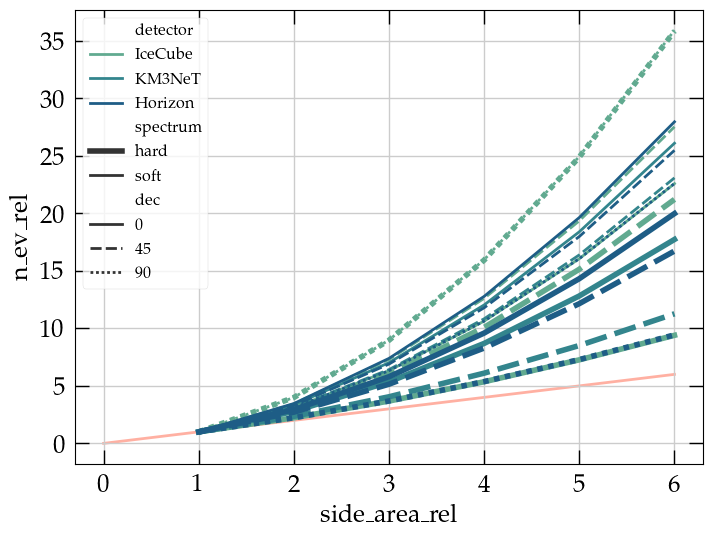

In [ ]:
plt.figure()
ax = sns.lineplot(
    data=results,
    x="top_area_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([0, 35], [0, 35], color="tomato", ls="-", zorder=0, alpha=0.5)
plt.figure()
ax = sns.lineplot(
    data=results,
    x="side_area_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([0, 6], [0, 6], color="tomato", ls="-", zorder=0, alpha=0.5)

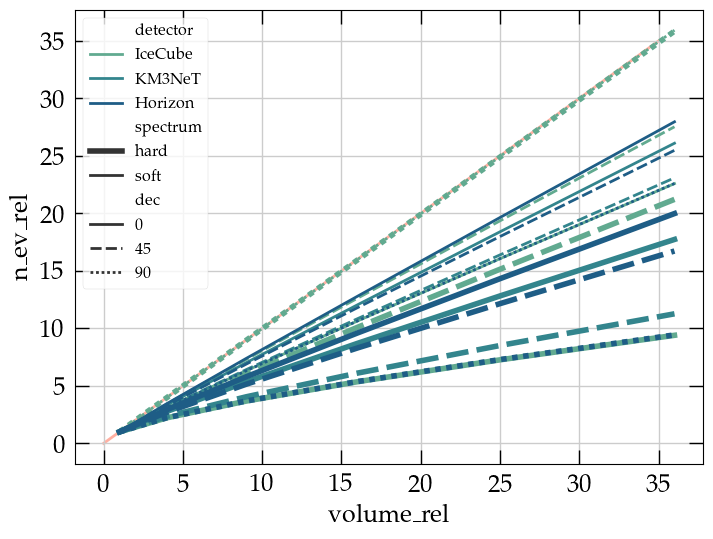

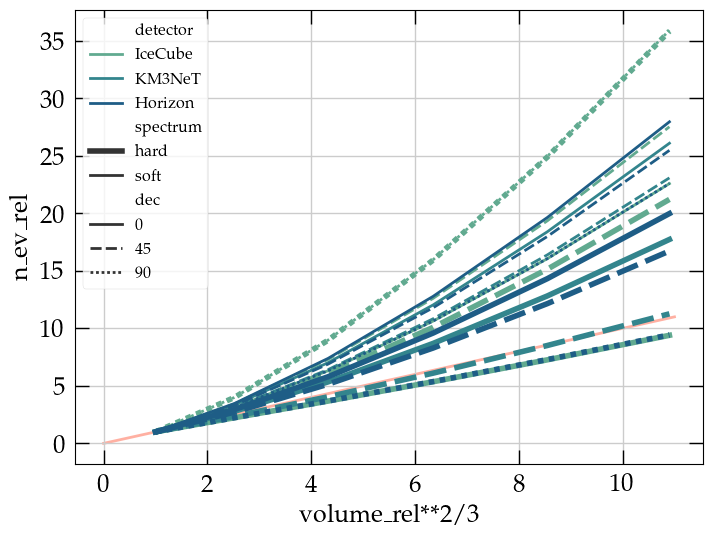

In [ ]:
plt.figure()
ax = sns.lineplot(
    data=results,
    x="volume_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([0, 35], [0, 35], color="tomato", ls="-", zorder=0, alpha=0.5)
plt.figure()
ax = sns.lineplot(
    data=results,
    x="volume_rel**2/3",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
    sizes=[4, 2],
)
plt.legend(fontsize="small")
plt.plot([0, 11], [0, 11], color="tomato", ls="-", zorder=0, alpha=0.5)

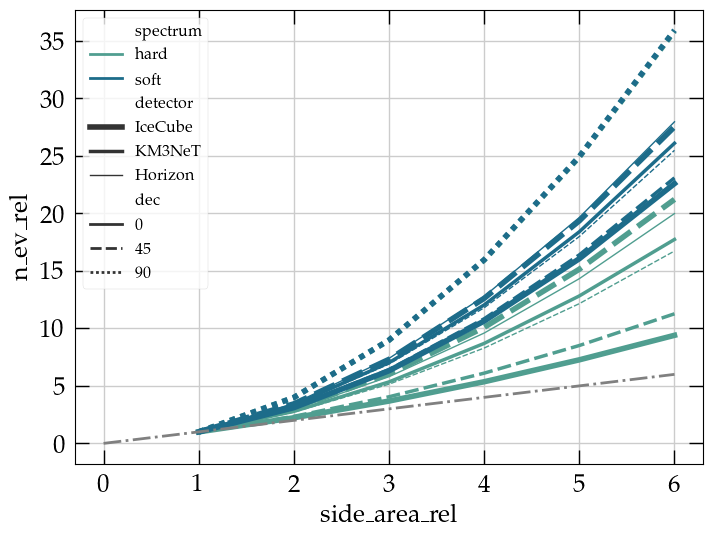

In [ ]:
ax = sns.lineplot(
    data=results,
    x="side_area_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
)
plt.plot([0, 6], [0, 6], color="tomato", ls="-")
# plt.plot([0, 6], [0, 12], color="tomato", ls="-")
plt.legend(fontsize="small")
# ax.loglog()

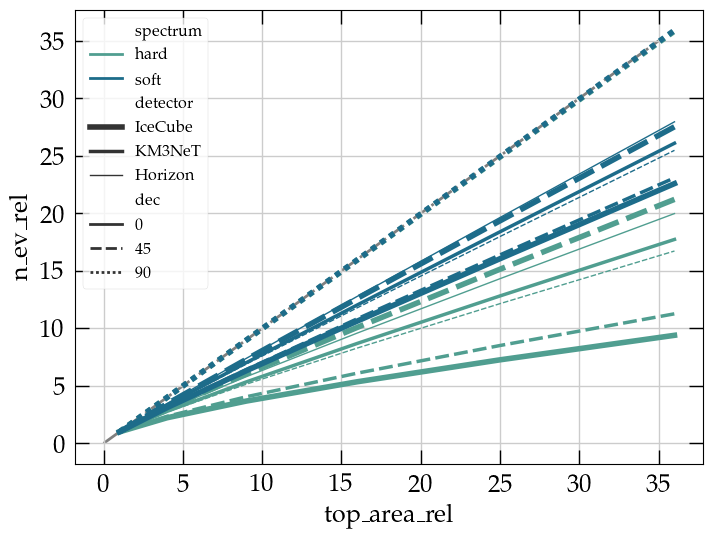

In [ ]:
ax = sns.lineplot(
    data=results,
    x="top_area_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
)
plt.plot([0, 35], [0, 35], color="tomato", ls="-", zorder=0, alpha=0.5)
plt.legend(fontsize="small")

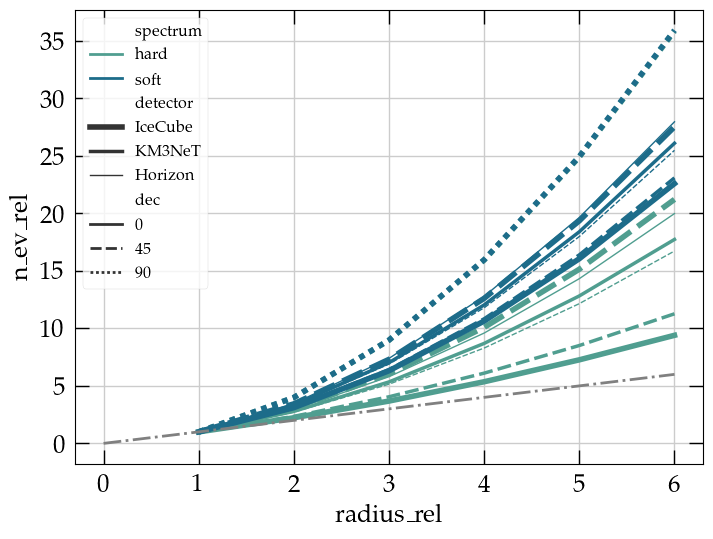

In [ ]:
ax = sns.lineplot(
    data=results,
    x="radius_rel",
    y="n_ev_rel",
    size="spectrum",
    style="dec",
    hue="detector",
    palette="crest",
)

plt.plot([0, 6], [0, 6], color="tomato", ls="-")
plt.legend(fontsize="small")
# ax.loglog()

# diffuse style


In [ ]:
# generic diffuse flux config
diffuse_config = dict(
    sindec_width=st.sindec_width,
    ra_width=st.ra_width,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    diff_or_ps="diff"
)
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
# the simple power-law flux has 3 shape parameters (norm, gamma, E0) and a name ("powerlaw")
diffuse_flux = PL_flux(st.PHI_ASTRO, st.GAMMA_ASTRO, st.E_NORM, "powerlaw")

aeff_factor = calc_aeff_factor(aeff_2d, **diffuse_config)

k_s = astro_flux(
    aeff_factor,
    st.emids,
    energy_resolution=None,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)

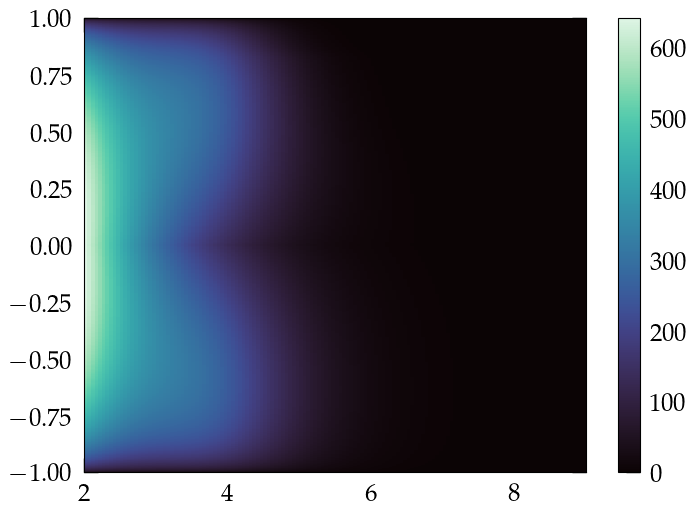

In [ ]:
plt.pcolormesh(st.logE_bins, st.sindec_bins, k_s, vmin=0) #, norm=LogNorm(vmin=1e-5, vmax=20))
plt.colorbar()

In [ ]:
np.sum(k_s)

7045587.319248982